# Build subsurface model and forcing for Atlantis
This example shows how to build a subsurface model that has the correct input variables for subsidence modelling in [Atlantis Julia](https://gitlab.com/deltares/subsidence/atlans.jl). The model is built for an example area of 5x5 km nearby Utrecht. The area is shown in the figure below.

Text(74.6722222222222, 0.5, 'Northing [m]')

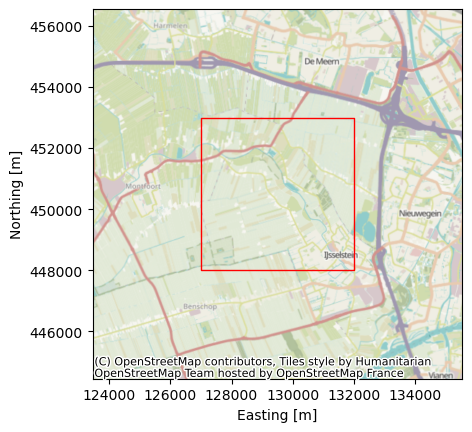

In [2]:
import contextily as ctx # for background maps
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import box

xmin, xmax = 127_000, 132_000
ymin, ymax = 448_000, 453_000

gdf_area = gpd.GeoDataFrame(geometry=[box(xmin, ymin, xmax, ymax)], crs=28992)

# plot the area and cross-section line
fig, ax = plt.subplots()
gdf_area.plot(ax=ax, facecolor='none', edgecolor='r')
gdf_area.buffer(3000).plot(ax=ax, facecolor='none', edgecolor='none')
ctx.add_basemap(ax=ax, crs=gdf_area.crs)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')


# Input data
A complete model for the Netherlands and with the most level of detail is composed from the [BRO bodemkaart](), [GeoTOP](), [NL3D](), [AHN]() and a mean lowest groundwater table: the GLG. Below is an overview per data source:
- BRO bodemkaart: soilmap of the complete Netherlands documenting the subsurface buildup to a depth of 1.2 m below the surface level.
- GeoTOP: 3-dimensional voxelmodel documenting the stratigraphic and lithological subsurface buildup of the first 50 m below the surface level for most of the Netherlands (modelling for the rest of NL is still in progress). The model resolution is 100 x 100 x 0.5 [x, y, z].
- NL3D: 3-dimensional voxelmodel documenting the stratigraphic and lithological subsurface buildup to 20 m below the surface level for the entire Netherlands. The model resolution is 250 x 250 x 1 [x, y, z] and in contrast with GeoTOP, does not differentiate between Holocene units (i.e. Holocene is a single unit).
- AHN (Algemeen Hoogtebestand Nederland): Lidar surface level measurements for the entire Netherlands (excl. water bodies) with 0.5 x 0.5 m resolution.
- GLG: A mean lowest groundwater table. Input for this usually comes from national scale groundwater models. A national GLG is also openly available via the [BRO](https://basisregistratieondergrond.nl/inhoud-bro/registratieobjecten/modellen/model-grondwaterspiegeldiepte-wdm/).

To build a subsurface model suitable for Atlantis, AHN and GeoTOP are mandatory input. The other sources are optional. The area of this example is entirely covered by GeoTOP so only AHN, GeoTOP and the BRO Bodemkaart will be used. A GLG is thus optional and can be added at any time to the NetCDF of the eventual subsurface model.

It is not possible to access the BRO bodemkaart directly so this must first be downloaded as a geopackage from the link at the top of the section. Also a selection of AHN must be downloaded (see link at the top) and converted to a 100 x 100 m grid. GeoTOP data can directly be accessed from an OPeNDAP server.

Below, the necessary tools are imported and the data to build the model with are instantiated.

In [9]:
from atmod import (
    AtlansParameters,
    build_atlantis_model,
    read_ahn
)
from atmod.bro_models import BroBodemKaart, GeoTop
from pathlib import Path


bbox  = (127_000, 448_000, 132_000, 453_000) # xmin, ymin, xmax, ymax of the example area

path_to_soilmap = 'bro_bodemkaart.gpkg'
path_to_ahn = 'dtm_100m.tif'

path_to_soilmap = r'c:\Users\knaake\OneDrive - Stichting Deltares\Documents\data\dino\bro_bodemkaart.gpkg'
path_to_ahn = r'p:\430-tgg-data\ahn\dtm_100m.tif'

ahn = read_ahn(path_to_ahn, bbox=bbox)
soilmap = BroBodemKaart.from_geopackage(path_to_soilmap, bbox=bbox)
geotop = GeoTop.from_opendap(bbox=bbox, data_vars=['strat', 'lithok'], lazy=False)

Load data


The above reads all data sources in the extent of the example area. GeoTOP is thus directly accessed from the OPeNDAP server, the method has the required url for the data. Only the 'strat' and 'lithok' variables of GeoTOP are downloaded as these are only required to build a subsurface model. Additionally, the 'lazy' keyword is set to False. This reads all data into memory which decreases the time it costs to build a complete model. Note that if the model area is larger, that a devices memory may not be sufficient and a model must be built in parts.

Building a model also needs a selection of input paramaters for parameterizing several data variables. Atmod has a class `AtlansParameters` where each input parameter can be specified. If a parameter is not specified, a default parameter is used. This example uses only defaults. The output shows the optional input parameters

In [18]:
parameters = AtlansParameters() # initialize with all default parameters

params = [f'{k}: {v}' for k, v in parameters.__dict__.items()]
instance = parameters.__class__.__name__
params = '\n\t'.join(params)
print(f'{instance}\n\t{params}')

AtlansParameters
	modelbase: -30.0
	mass_fraction_organic: 0.5
	mass_fraction_lutum: 0.5
	rho_bulk: 833.0
	shrinkage_degree: 0.7
	max_oxidation_depth: 1.2
	no_oxidation_thickness: 0.3
	no_shrinkage_thickness: 0.0


Finally, building a model is quite simple.

In [ ]:
model = build_atlantis_model(ahn, geotop, bodemkaart=soilmap, parameters=parameters)